In [1]:
from jaxl.constants import *
from jaxl.datasets import get_dataset
from jaxl.learning_utils import get_learner
from jaxl.utils import parse_dict

import json
import numpy as np
import os

from orbax.checkpoint import PyTreeCheckpointer, CheckpointManager

In [2]:
# learner_path = "/Users/chanb/research/personal/jaxl/jaxl/logs/icl-linear_sgd-full_context_20/gpt-no_enc-08-18-23_12_04_06-5f798728-1621-42b1-a08d-1425f60bbe90"
learner_path = "/Users/chanb/research/personal/jaxl/jaxl/logs/icl-linear_sgd-full_context_20/gpt-pos_enc-08-18-23_12_04_04-b2ae6878-3b72-4971-a34b-7c63bac24143"
test_dataset_seed = 9999

In [3]:
config_path = os.path.join(learner_path, "config.json")
with open(config_path, "r") as f:
    config_dict = json.load(f)
    config = parse_dict(config_dict)
    
learner = get_learner(
    config.learner_config, config.model_config, config.optimizer_config
)

checkpoint_manager = CheckpointManager(
    os.path.join(learner_path, "models"),
    PyTreeCheckpointer(),
)

params = checkpoint_manager.restore(checkpoint_manager.latest_step())
params[CONST_MODEL_DICT][CONST_MODEL][CONST_POSITIONAL_ENCODING] = dict()
model = learner._model

In [4]:
config.learner_config.dataset_config

namespace(dataset_name='multitask_toy_regression',
          dataset_kwargs=namespace(basis='polynomial',
                                   degree=1,
                                   num_sequences=100000,
                                   sequence_length=41,
                                   noise=0.1,
                                   params_bound=[-10.0, 10.0],
                                   val_frac=0.0005),
          dataset_wrapper=namespace(type='ContextDataset',
                                    kwargs=namespace(context_len=20,
                                                     skip_step=1)))

In [5]:
sequence_len = 80
test_config = vars(config.learner_config.dataset_config)
test_config["dataset_kwargs"] = vars(test_config["dataset_kwargs"])
test_config["dataset_kwargs"]["sequence_length"] = sequence_len + 1
test_config = parse_dict(test_config)

In [6]:
test_dataset = get_dataset(test_config, seed=test_dataset_seed)

In [7]:
def get_result(dataset, sequence_length):
    context_inputs, context_outputs, queries, outputs = [], [], [], []
    for seq_i in range(sequence_length):
        context_input, context_output, query, output = dataset[seq_i]
        context_inputs.append(context_input)
        context_outputs.append(context_output)
        queries.append(query)
        outputs.append(output)
    context_inputs = np.stack(context_inputs)
    context_outputs = np.stack(context_outputs)
    queries = np.stack(queries)
    outputs = np.stack(outputs)

    preds, _ = model.forward(
        params[CONST_MODEL_DICT][CONST_MODEL],
        queries,
        {
            CONST_CONTEXT_INPUT: context_inputs,
            CONST_CONTEXT_OUTPUT: context_outputs,
        }
    )
    return queries, preds, outputs

In [8]:
def mse(preds, outputs):
    return np.mean((preds - outputs) ** 2)

In [9]:
queries, preds, outputs = get_result(
    test_dataset,
    sequence_length=sequence_len
)
loss = mse(preds, outputs)
print(queries.shape, preds.shape, outputs.shape)

(80, 1, 1) (80, 1) (80, 1)


In [10]:
loss

Array(0.5003449, dtype=float32)

# Plotting

In [11]:
import matplotlib.pyplot as plt

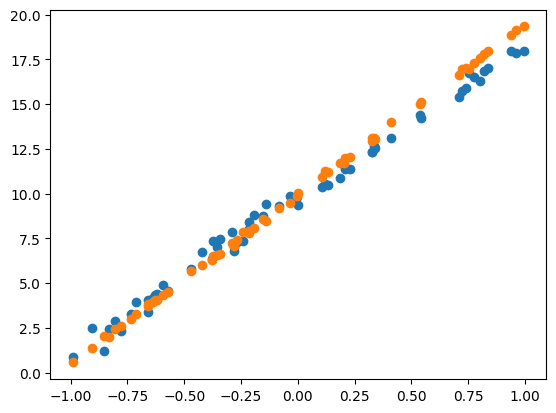

In [12]:
context_len = config.learner_config.dataset_config.dataset_wrapper.kwargs.context_len
plt.scatter(queries[context_len:], preds[context_len:])
plt.scatter(queries[context_len:], outputs[context_len:])